In [1]:
import json
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tqdm import tqdm
import random
import numpy as np

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
file = '/data/predict/196E2517293A9285/196E2517293A9285_logs.json'

In [4]:
with open(file, encoding='utf8') as f:
    for line in tqdm(f):
        data = json.loads(line)
        if len(data['cart']) > 0:
            print(data)
            break

0it [00:00, ?it/s]

{'cart': ['A30041320767'], 'viewed_products': ['A30032711019'], 'visitor_id': '8FB43784894ECBA', 'merchant_id': '196E2517293A9285', 'purchased_products': [], 'timestamp': '20171116T122530Z', 'session_id': '1000A36B56BC1274'}


In [4]:
users = {}
with open(file, encoding='utf8') as f:
    for line in tqdm(f):
        data = json.loads(line)
        if data['visitor_id'] not in users:
            users[data['visitor_id']] = []
        for prod_idx in data['viewed_products']:
            try:
                users[data['visitor_id']].append(prod_idx)
            except ValueError: 
                print('Sktrain_labelsiped ' + prod_idx)

0it [00:00, ?it/s]

{'cart': [], 'purchased_products': [], 'viewed_products': ['A25256511054'], 'merchant_id': '196E2517293A9285', 'timestamp': '20171116T113136Z', 'visitor_id': '46CED85B0283DDC1', 'session_id': '10000D52BF111C72'}


In [6]:
#sessions_lens = list(map(lambda x: len(x), sessions.values()))
users_lens = list(map(lambda x: len(x), users.values()))

In [7]:
#print(len(sessions.keys()))
print(len(users.keys()))

120227


In [8]:
#d = plt.hist(sessions_lens, bins=100, range=(3, 103))

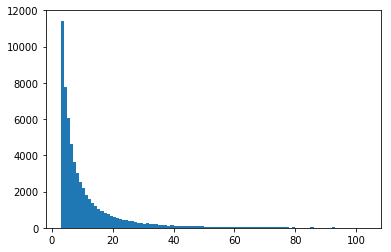

In [9]:
d = plt.hist(users_lens, bins=100, range=(3, 103))

In [10]:
products = {}
for u in users.values():
    for pid in u:
        products[pid] = 1
product_idxs = products.keys()
product_ids = {v: k for k, v in enumerate(product_idxs)}
number_of_classes = len(product_idxs)

In [11]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [12]:
def dedup(seq):
    seen = set()
    seen_add = seen.add

    return [x for x in seq if not (x in seen or seen_add(x))]


users_with_product_idxs = {}
for uid,products in users.items():
    ids = dedup(list(map(lambda x: product_ids[x], products)))[-40:]
    if len(ids) > 1:
        if len(ids) not in users_with_product_idxs:
            users_with_product_idxs[len(ids)] = []
        users_with_product_idxs[len(ids)].append(ids)
    
#del users

In [13]:
max_batch_size = 32
test_size = 0.1
user_batches = []
user_valid_batches = []
for len_group in users_with_product_idxs.values():
    random.shuffle(len_group)
    for batch in chunks(len_group, max_batch_size):
        batch_data = np.array(list(map(lambda x: x[:-1], batch)))
        batch_labels = np.expand_dims(np.array(list(map(lambda x: x[1:], batch))), axis=2)
        if random.random() < test_size:
            user_valid_batches.append(
                (batch_data, batch_labels)
            )
        else:
            user_batches.append(
                (batch_data, batch_labels)
            )

In [14]:

def generate_from_array(arr):
    while True:
        random.shuffle(arr)
        for i in arr: 
            yield i
    

In [33]:
#raw_data = []
#raw_abels  = []
#for products in tqdm(users_with_product_idxs):
#    if(len(products) > 1):
#        for i in range(len(products) - 6):
#            raw_data.append(np.array(products[:-1]))
#            raw_abels.append(np.array(products[-1]))

In [34]:
#data_np = np.stack(raw_data)
#labels_np = np.expand_dims(np.stack(raw_abels), axis=1)

In [35]:
#from sklearn.model_selection import train_test_split
#train_data, valid_data, train_labels, valid_labels  = train_test_split(data_np , labels_np, test_size=0.10, shuffle=True)

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNGRU, Dense, Dropout, TimeDistributed,Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.optimizers import Nadam


n_hidden = 200

model=Sequential([
        Embedding(number_of_classes, n_hidden, batch_input_shape=(None,None)),
        BatchNormalization(),
        CuDNNGRU(4*n_hidden, input_shape=(None,n_hidden),return_sequences=True),
        Dropout(0.2),
        CuDNNGRU(4*n_hidden,return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(n_hidden)),
        TimeDistributed(Dense(number_of_classes, activation='softmax'))
    ])

In [16]:
from keras.backend import reshape, prod, shape, stack
from keras.metrics import sparse_top_k_categorical_accuracy

def flatten_first_n_dimension(x, first_n=2):
    new_dims = stack([prod(shape(x)[:first_n]), prod(shape(x)[first_n:])])

    return reshape(x, new_dims)

def sparse_timedistributed_top_k_categorical_accuracy(y_true, y_pred, k=5):
    y_true_reshaped = flatten_first_n_dimension(y_true)
    y_pred_reshaped = flatten_first_n_dimension(y_pred)

    return sparse_top_k_categorical_accuracy(y_true_reshaped, y_pred_reshaped, k)

In [17]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy',sparse_timedistributed_top_k_categorical_accuracy], optimizer=Nadam())

In [103]:
model.fit_generator(
    generate_from_array(user_batches), 
    validation_data=generate_from_array(user_valid_batches), 
    steps_per_epoch=len(user_batches),
    validation_steps=len(user_valid_batches),
    epochs=4
)

Epoch 1/4
2012/2012 [==============================] - 27s 13ms/step - loss: 4.7868 - sparse_categorical_accuracy: 0.1871 - sparse_timedistributed_top_k_categorical_accuracy: 0.3797 - val_loss: 4.9192 - val_sparse_categorical_accuracy: 0.1948 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.3812
Epoch 2/4
2012/2012 [==============================] - 26s 13ms/step - loss: 4.7399 - sparse_categorical_accuracy: 0.1903 - sparse_timedistributed_top_k_categorical_accuracy: 0.3844 - val_loss: 4.8945 - val_sparse_categorical_accuracy: 0.1996 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.3894
Epoch 3/4
2012/2012 [==============================] - 26s 13ms/step - loss: 4.6943 - sparse_categorical_accuracy: 0.1944 - sparse_timedistributed_top_k_categorical_accuracy: 0.3914 - val_loss: 4.9006 - val_sparse_categorical_accuracy: 0.1966 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.3842
Epoch 4/4
2012/2012 [==============================] - 26s 13ms/step - loss: 4.

In [39]:
#model.fit(train_data, train_labels,validation_data=(valid_data,valid_labels), batch_size=256, epochs=4, shuffle=True)

In [40]:
model.save('/data/predict/196E2517293A9285/196E2517293A9285_predict_v1_dedup.h5')

In [41]:
model.save_weights('/data/predict/196E2517293A9285/196E2517293A9285_predict_weights_v1_dedup.h5')

In [18]:
model.load_weights('/data/predict/196E2517293A9285/196E2517293A9285_predict_weights_v1_dedup.h5')

In [42]:
#import csv
#with open('/data/predict/196E2517293A9285/196E2517293A9285_product_ids_1_dedup.csv', 'w') as csvfile:
#    spamwriter = csv.writer(csvfile)
#    for line in product_idxs:
#        spamwriter.writerow([line])

## Eye ball validation

In [19]:
import csv

In [20]:
product_map = {}
with open('/data/predict/196E2517293A9285/196E2517293A9285_catalog.csv', 'r', encoding='utf8') as csvfile:
    spamreader = csv.reader(csvfile)
    next(spamreader)
    for row in spamreader:
        product_map[row[10]] = [row[9], row[6], row[11]]

In [21]:
#product_map = {}
#with open('/data/predict/196E2517293A9285/196E2517293A9285_image_links.csv', 'r') as csvfile:
#    spamreader = csv.reader(csvfile)
#    for row in spamreader:
#        product_map[row[0]] = row[1]

In [27]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def product_to_url(product):
    try:
        return [product] + product_map[list(product_idxs)[product]]
    except KeyError:
        return [product,'http://www.lackuna.com/wp-content/themes/fearless/images/missing-image-640x360.png','UNKNOWN','']

def display_session(session):
    products = list(map(product_to_url, session))
    predictions = model.predict([session])
    html = '<table>'
    seen = set()
    for i,product in enumerate(products):
        html += '<tr>'
        html += '<th style="text-align:center">'
        html += '<img src="' + product[1] + '" width="130"><br/>' 
        html += '<a href="'+str(product[3])+'">' + str(product[0]) + '</a></br>' + str(product[2])
        html += '</th><td style="background-color:black;"></td>'
        top_idx = list(np.argsort(predictions[i][0])[::-1])
        seen.add(product[0])
        
        j = 0
        for pred in top_idx:
            if pred in seen:
                continue
                                
            if i < len(products) - 1 and pred == products[i+1][0]:
                style = 'style="border:3px dashed red;"'
            else:
                style = ''
                
            pred_data = product_to_url(pred)
            html += '<td><img src="' + pred_data[1] + '" '+style+' width="130"><br/>' 
            html += '<a href="'+str(pred_data[3]) + '">' +str(pred_data[0]) + '</a></br>' + str(pred_data[2]) + '</td>'
            j+=1
            if j > 5:
                break
                
        html += '</tr>'
    html += '</table>'

    core_display(HTML(html))

display_session(random.choice(random.choice(user_valid_batches)[0]))

370Printkleid mit Raffärmel,,1693UNKNOWN,499Jacquardstreifen Rock Shiva,1040UNKNOWN,977UNKNOWN,1596Kurze gestreifte Jacke Marry,2324Organic Halbarm Shirt Lenka
437Kleid mit gerafftem Ärmel,,1725UNKNOWN,1939UNKNOWN,262UNKNOWN,258Zarter Flammgarn Bolero,1889Strukturmix Shirt Ulrika,1878Glitzerprint Shirt Elsine
1827Kleid mit gerafftem Ärmel,,2173Gecrashtes V-Neck Shirt,1233Pulli mit Zickzack Struktur,810Slim Fit Jacquard Hose Yella,75Shirt mit breiter Rüsche,609UNKNOWN,1869Trägertop aus Organic Cotton
2023Kleid mit gerafftem Ärmel,,218Kurze Fischgrätmuster Jacke,1874Struktur Sweatblazer Elfie,978Gewebter Basic Rock Gisou,997Leichte Viskosebluse,894UNKNOWN,488UNKNOWN
2076Fließendes Strukturmix Shirt,,952Lässige Crash Bermuda Jannis,1394Shirt mit Wording Sheila,776Zarte Blütenprint Bluse,1214Crashshirt mit Glitzerkante,1187Longsleeve mit Schleifen,1896Organic Rundhalstop Bethy
898Fließendes Strukturmix Shirt,,101UNKNOWN,780Longsleeve mit Spitzenpasse,2403Schal mit großen Blüten,353Asymmetrisches Chiffonkleid,1619Softe Ornamentprint Bluse,970Printshirt mit Stick-Passe
2273Fließendes Strukturmix Shirt,,1049Pailletten Joggpants Leila,64Kurzblazer mit Zippertaschen,2222Melierter Filzmantel,806Offene Rippmuster Longjacke,1603UNKNOWN,551Silberprint Loop Wiebke
602Fließendes Strukturmix Shirt,,183Dunkle Jeans York,500UNKNOWN,912Organic Cotton Spaghettitop,858Slim Hose mit Zipper Yulius,1997Leichte Longjacke mit Kapuze,1391Gerippter Turtleneck Pulli
137Blockstreifen Shirt Gitta,,1005Tunika Bluse mit Kästchen,1968Rippbündchen Tunika Bluse,2162Blusentop im Ikat-Print,1361Softes Turtleneck Top,23UNKNOWN,1533Meliertes Sweatkleid
1837Kleid mit Nackenschleife,,1442Bluse mit Print Amalia,1367Hemdbluse im Long Style,816Organic Longtop Layri,838Kurzarm Bluse Vivia,614Blütenprint Chiffon Top,640Flausch Pullover Marie
1783Kleid mit Nackenschleife,,1912Grafikprinttop mit Bändchen,1899Oversize Pulli mit Rippärmel,1752Kurze Struktur Zipperjacke,1263Kurzarm Bluse Vivia,932UNKNOWN,"695Warmer, großer Wende-Schal"
